In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import folium
import geopy
import geopandas as gpd

In [2]:
d = {'Topic_key_word': [1,2,3,4,5,6,7,8,9,10], 
     'Key words': ['job', 'election,momey,covid,support', 'australia,family','photo,australia','family,australia','family,hope',
                   'australia,family','country,change','team,win,country','governemnt,labor,vote']}
df_word = pd.DataFrame(data=d)

df_tw = pd.read_csv('../Data/Twitter_LDA.csv')
df_tw = df_tw.merge(df_word, left_on="Topic_key_word", right_on="Topic_key_word")
df_tw = df_tw[~(df_tw['Greater Capital City'].str[1] == 'r')]

def labeling(x):
    if x < 0 and x >= -2:
        return 'negative'
    elif x < -2:
        return 'very negative'
    elif x==0:
        return 'neutral'
    elif x > 0 and x <= 2:
        return 'positive'
    else:
        return 'very positive'
df_tw["sentiment_la"]=df_tw["sentiment"].map(lambda x: labeling(x))

df_tw["Latitude"] = (df_tw["bottom"] + df_tw["top"])/2
df_tw["Longitude"] = (df_tw["left"] + df_tw["right"])/2

array = [2]
df_cov = df_tw.loc[df_tw.Topic_key_word.isin(array)].reset_index(drop=True)
df_cov.to_csv('../Data/twiter_topic_cov.csv')
array = [3, 5, 7]
df_fam = df_tw.loc[df_tw.Topic_key_word.isin(array)].reset_index(drop=True)
df_fam.to_csv('../Data/twiter_topic_fam.csv')
array = [10]
df_job = df_tw.loc[df_tw.Topic_key_word.isin(array)].reset_index(drop=True)
df_job.to_csv('../Data/twiter_topic_job.csv')

In [3]:
df_tw[df_tw['cleaned_text'].str.contains('job')]

,Unnamed: 0,author_id,cleaned_text,sentiment,gcc,left,bottom,right,top,Language,Greater Capital City,Topic_key_word,Key words,sentiment_la,Latitude,Longitude
105,253,1108711866212052993,not|the|guy|that|took|the|job|wanted|were|the|...,0.000000,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,1,job,neutral,-32.150100,115.928319
119,296,51403576,one|asked|what|her|partner|did|for|are|not|the...,0.019231,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,1,job,positive,-32.150100,115.928319
425,1038,3091736826,yes|for|several|years|one|first|jobs|and|out|l...,0.058824,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,1,job,positive,-32.150100,115.928319
685,1666,709642244836478976,going|job|tomorrow|again|off,0.300000,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,1,job,positive,-32.150100,115.928319
869,2128,28356058,lol|you|tattooed|you|can|potentially|get|fired...,0.058824,perth,115.617614,-32.675715,116.239023,-31.624486,en,5gper,1,job,positive,-32.150100,115.928319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180147,2365088,9360352,think|quite|few|were|paid|well|for|doing|their...,0.000000,carnegie,145.044690,-37.906499,145.067459,-37.881020,en,2gmel,3,"australia,family",neutral,-37.893759,145.056075
2181192,2396322,624351146,the|problem|with|the|generation|millennials|th...,0.000000,menangle,150.736104,-34.134971,150.743099,-34.125377,en,1gsyd,3,"australia,family",neutral,-34.130174,150.739602
2181193,2396324,624351146,the|problem|with|the|generation|millennials|th...,0.000000,menangle,150.736104,-34.134971,150.743099,-34.125377,en,1gsyd,3,"australia,family",neutral,-34.130174,150.739602
2181893,2413416,76908648,the|home|factor|australian|sport|strange|don|s...,-0.038462,keysborough,145.137298,-38.032846,145.194737,-37.979907,en,2gmel,3,"australia,family",negative,-38.006377,145.166018


In [4]:
len(df_fam)+len(df_job)+len(df_cov)

555858

The number of positive is 973101: 0.4018755273294488
The number of very positive is 413: 0.000170562554952736
The number of neutral is 947741: 0.3914022430834406
The number of negative is 499873: 0.20643974826123246
The number of very negative is 271: 0.00011191877092540305


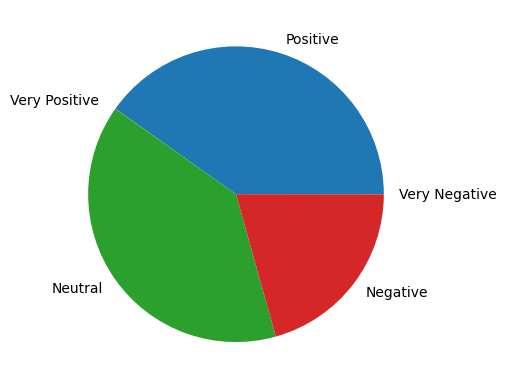

In [5]:
df_twall = pd.read_csv('../Data/twitter_clean.csv')
#df_twall = df_twall.drop(df_tw.keys()[0], axis=1)
df_twall["Latitude"] = (df_twall["bottom"] + df_twall["top"])/2
df_twall["Longitude"] = (df_twall["left"] + df_twall["right"])/2

df_twall["sentiment_la"]=df_twall["sentiment"].map(lambda x: labeling(x))
num_total = len(df_twall)
num_pos = len(df_twall[(df_twall['sentiment_la']=='positive')])
num_vpos = len(df_twall[(df_twall['sentiment_la']=='very positive')])
num_neu = len(df_twall[(df_twall['sentiment_la']=='neutral')])
num_neg = len(df_twall[(df_twall['sentiment_la']=='negative')])
num_vneg = len(df_twall[(df_twall['sentiment_la']=='very negative')])

print('The number of positive is ' + str(num_pos) + ": " + str(num_pos/num_total))
print('The number of very positive is ' + str(num_vpos) + ": " + str(num_vpos/num_total))
print('The number of neutral is ' + str(num_neu) + ": " + str(num_neu/num_total))
print('The number of negative is ' + str(num_neg) + ": " + str(num_neg/num_total))
print('The number of very negative is ' + str(num_vneg) + ": " + str(num_vneg/num_total))
y = np.array([num_pos, num_vpos, num_neu, num_neg, num_vneg])
mylabels = ["Positive", "Very Positive ", "Neutral", "Negative", "Very Negative"]
plt.pie(y, labels = mylabels)
plt.show()

In [6]:
city = "perth"
# get location
locator = geopy.geocoders.Nominatim(user_agent="My app") 
city = locator.geocode(city)
location = [city.latitude, city.longitude]
print(city, "\n[lat, long]:", location)

Perth, City of Perth, Western Australia, 6000, Australia 
[lat, long]: [-31.9558933, 115.8605855]


In [7]:
sf_gcc = gpd.read_file("../Data/gcc_sf/GCCSA_2021_AUST_GDA2020.shp")
sf_gcc['Greater Capital City'] = sf_gcc['GCC_CODE21'].str.lower()
col = ['Greater Capital City', 'geometry']
sf_gcc1 = sf_gcc[col]
df_twall_sf = df_twall.merge(sf_gcc1, left_on="Greater Capital City", right_on="Greater Capital City")
df_tw_sf = df_tw.merge(sf_gcc1, left_on="Greater Capital City", right_on="Greater Capital City")

gdf_gcc = gpd.GeoDataFrame(sf_gcc)
geoJSON_gcc = gdf_gcc[['Greater Capital City', 'geometry']].drop_duplicates('Greater Capital City').to_json()

In [8]:
sf_sa4 = gpd.read_file("../Data/sa4_sf/SA4_2021_AUST_GDA2020.shp")
sf_sa4['Greater Capital City'] = sf_sa4['GCC_CODE21'].str.lower()
col = ['Greater Capital City', 'geometry', 'SA4_CODE21']
sf_sa4_ = sf_sa4[col]
sf_sa4_['sa4_code'] = sf_sa4_['SA4_CODE21']
sf_sa4_ = sf_sa4_[pd.to_numeric(sf_sa4_['sa4_code'], errors='coerce').notnull()]
sf_sa4_['sa4_code'] = sf_sa4_['sa4_code'].astype(np.int64)

df_mel_sd = pd.read_csv('../Data/mel_sd.csv')
df_mel_sd['sa4_code'] = df_mel_sd[' sa4_code_2016']
df_mel_sd = df_mel_sd.merge(sf_sa4_, left_on="sa4_code", right_on="sa4_code")
gdf_mel = gpd.GeoDataFrame(df_mel_sd)
geoJSON_mel = gdf_mel[['sa4_code', 'geometry']].drop_duplicates('sa4_code').to_json()

df_bri_sd = pd.read_csv('../Data/bri_sd.csv')
df_bri_sd['sa4_code'] = df_bri_sd[' sa4_code_2016']
df_bri_sd = df_bri_sd.merge(sf_sa4_, left_on="sa4_code", right_on="sa4_code")
gdf_bri = gpd.GeoDataFrame(df_bri_sd)
geoJSON_bri = gdf_bri[['sa4_code', 'geometry']].drop_duplicates('sa4_code').to_json()

df_syd_sd = pd.read_csv('../Data/syd_sd.csv')
df_syd_sd['sa4_code'] = df_syd_sd[' sa4_code_2016']
df_syd_sd = df_syd_sd.merge(sf_sa4_, left_on="sa4_code", right_on="sa4_code")
gdf_syd = gpd.GeoDataFrame(df_syd_sd)
geoJSON_syd = gdf_syd[['sa4_code', 'geometry']].drop_duplicates('sa4_code').to_json()

df_per_sd = pd.read_csv('../Data/per_sd.csv')
df_per_sd['sa4_code'] = df_per_sd[' sa4_code_2016']
df_per_sd = df_per_sd.merge(sf_sa4_, left_on="sa4_code", right_on="sa4_code")
gdf_per = gpd.GeoDataFrame(df_per_sd)
geoJSON_per = gdf_per[['sa4_code', 'geometry']].drop_duplicates('sa4_code').to_json()

/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
print(df_job['sentiment'].mean())
print(df_fam['sentiment'].mean())
print(df_cov['sentiment'].mean())
print(df_tw['sentiment'].mean())
print(df_twall['sentiment'].mean())

0.05961853397629328
0.10862669951102139
0.054843756870152305
0.07467023981539059
0.07146553755594454


In [10]:
df_twall_sf['Greater Capital City'].value_counts()


Greater Capital City
2gmel    685379
1gsyd    634994
3gbri    287258
5gper    192602
4gade    151982
1rnsw    144149
2rvic    106670
8acte     59458
6ghob     47863
3rqld     30642
5rwau     22211
7gdar     17581
4rsau     16028
6rtas     13928
7rnte     10615
9oter        39
Name: count, dtype: int64

In [11]:
sf_sa4_.head()

,Greater Capital City,geometry,SA4_CODE21,sa4_code
0,1rnsw,"MULTIPOLYGON (((150.05261 -37.26253, 150.05251...",101,101
1,1gsyd,"MULTIPOLYGON (((151.31497 -33.55578, 151.31496...",102,102
2,1rnsw,"POLYGON ((150.14236 -32.34153, 150.14255 -32.3...",103,103
3,1rnsw,"MULTIPOLYGON (((153.07639 -30.42982, 153.07645...",104,104
4,1rnsw,"POLYGON ((148.67619 -29.50976, 148.67662 -29.5...",105,105


In [12]:
m_Twitterall = folium.Map(location=[-20.81,124.96], zoom_start=5)
c = folium.Choropleth(
    geo_data = geoJSON_gcc,
    name = 'choropleth',
    data = df_twall_sf,
    columns = ['Greater Capital City','sentiment'],
    key_on= 'feature.properties.Greater Capital City',
    fill_color = 'YlOrRd',
    nan_fill_color = 'white',
    legend_name = 'sentiment'
)
c.add_to(m_Twitterall)
m_Twitterall.save('../Data/Twitter_all.html')

In [13]:
df_mel_sd.keys()

Index(['Unnamed: 0', 'As at 30 June, family tax benefit B',
       'disability support ', ' yr', 'rent assistant ', ' sa4_code_2016',
       ' sa4_name_2016', 'Youth allowance ', 'family tax A benefit ',
       'Greater Capital City_x', 'sa4_code', 'Greater Capital City_y',
       'geometry', 'SA4_CODE21'],
      dtype='object')

In [14]:
m_mel = folium.Map(location=[-37.81,144.96], zoom_start=9)
c = folium.Choropleth(
    geo_data = geoJSON_mel,
    name = 'choropleth',
    data = df_mel_sd,
    columns = ['sa4_code','Youth allowance '],
    key_on= 'feature.properties.sa4_code',
    fill_color = 'YlOrRd',
    nan_fill_color = 'white',
    legend_name = 'Number of people git youth allowance'
)
c.add_to(m_mel)
m_mel.save('../Data/Mel_ya.html')

In [15]:
m_bri = folium.Map(location=[-27.4689682, 153.0234991], zoom_start=9)
c = folium.Choropleth(
    geo_data = geoJSON_bri,
    name = 'choropleth',
    data = df_bri_sd,
    columns = ['sa4_code','Youth allowance '],
    key_on= 'feature.properties.sa4_code',
    fill_color = 'YlOrRd',
    nan_fill_color = 'white',
    legend_name = 'Number of people git youth allowance'
)
c.add_to(m_bri)
m_bri.save('../Data/Bri_ya.html')

In [16]:
m_syd = folium.Map(location=[-33.8698439, 151.2082848], zoom_start=9)
c = folium.Choropleth(
    geo_data = geoJSON_syd,
    name = 'choropleth',
    data = df_syd_sd,
    columns = ['sa4_code','Youth allowance '],
    key_on= 'feature.properties.sa4_code',
    fill_color = 'YlOrRd',
    nan_fill_color = 'white',
    legend_name = 'Number of people git youth allowance'
)
c.add_to(m_syd)
m_syd.save('../Data/Syd_ya.html')

In [17]:
m_per = folium.Map(location=[-31.9558933, 115.8605855], zoom_start=9)
c = folium.Choropleth(
    geo_data = geoJSON_per,
    name = 'choropleth',
    data = df_per_sd,
    columns = ['sa4_code','Youth allowance '],
    key_on= 'feature.properties.sa4_code',
    fill_color = 'YlOrRd',
    nan_fill_color = 'white',
    legend_name = 'Number of people git youth allowance'
)
c.add_to(m_per)
m_per.save('../Data/Per_ya.html')

In [18]:
df_tw_mel = df_tw.loc[df_tw['gcc']=='melbourne']
df_tw_mel_eg = df_tw_mel.loc[(df_tw_mel['sentiment'] < -1) | (df_tw_mel['sentiment'] > 1)]
df_tw_mel_eg.loc[df_tw_mel_eg["sentiment"]>0, ["color"]] = "More_positive"
df_tw_mel_eg.loc[df_tw_mel_eg["sentiment"]<0, ["color"]] = "More_negative"

In [19]:
df_tw_syd = df_tw.loc[df_tw['gcc']=='sydney']
df_tw_syd_eg = df_tw_syd.loc[(df_tw_syd['sentiment'] < -1) | (df_tw_syd['sentiment'] > 1)]
df_tw_syd_eg.loc[df_tw_syd_eg["sentiment"]>0, ["color"]] = "More_positive"
df_tw_syd_eg.loc[df_tw_syd_eg["sentiment"]<0, ["color"]] = "More_negative"

In [20]:
df_tw_syd['left'].value_counts()

left
150.520929    524566
151.197033       114
151.198850         6
151.206183         5
Name: count, dtype: int64

In [21]:
df_tw_syd['bottom'].value_counts()

bottom
-34.118347    524566
-33.879703       114
-33.893497         6
-33.873284         5
Name: count, dtype: int64

In [22]:
df_tw_syd['top'].value_counts()

top
-33.578141    524566
-33.856109       114
-33.893497         6
-33.873284         5
Name: count, dtype: int64

In [23]:
colors = {'More_negative' : 'red', 'More_positive' : 'blue'}

m_mel_eg = folium.Map(location=[-38.043995, 145.264296], zoom_start=11)

df_tw_mel_eg.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                              radius=10, fill_color=colors[row['color']])
                                             .add_to(m_mel_eg), axis=1)
m_mel_eg.save('../Data/Mel_eg_senti.html')

In [24]:
colors = {'More_negative' : 'red', 'More_positive' : 'blue'}

m_syd_eg = folium.Map(location=[-33.8698439, 151.2082848], zoom_start=11)

df_tw_syd_eg.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                              radius=10, fill_color=colors[row['color']])
                                             .add_to(m_syd_eg), axis=1)
m_syd_eg.save('../Data/Syd_eg_senti.html')

In [25]:
df_tw_mel_eg.keys()

Index(['Unnamed: 0', 'author_id', 'cleaned_text', 'sentiment', 'gcc', 'left',
       'bottom', 'right', 'top', 'Language', 'Greater Capital City',
       'Topic_key_word', 'Key words', 'sentiment_la', 'Latitude', 'Longitude',
       'color'],
      dtype='object')